### 一、数据

数据主要包括2010年1月1日至2014年12月31日间北京pm2.5指数以及相关天气指数数据。在预处理中需要每7天抽一个数据作为验证集，其余作为测试集。

### 二、数据预处理

将所有*pm2.5*列含有缺失值的数据都删除，将*cbwd*列数据独热码，并每7天抽一个数据作为验证集，其余作为测试集。

In [9]:
# import the packages
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error, f1_score

In [10]:
# data preprocessing
# read in data 
PRSA_df = pd.read_csv('./data/PRSA_data.csv')

# one-hot coding on cbwd
PRSA_df = pd.get_dummies(data=PRSA_df,columns=['cbwd'])

# date
PRSA_df['date'] = pd.to_datetime(PRSA_df[['year','month','day']])

# season
def season_divide(x):
    if x in range(3,6):
        return 'Spring'
    elif x in range(6,9):
        return 'Summer'
    elif x in range(9,12):
        return 'Autumn'
    else:
        return 'Winter'

PRSA_df['season'] = PRSA_df['month'].apply(season_divide)

# delete the nan statistics
no_nan_df = PRSA_df.drop(index=PRSA_df[PRSA_df['pm2.5'].isnull()].index).reset_index(drop=True)

# grade on pm2.5
no_nan_df['grade'] = no_nan_df['pm2.5'].apply(lambda x: 'low' if x<=35 else ('mid' if x<=150 else 'high'))

提取训练数据和测试数据

In [11]:
# get the train set and test set
yy = 2010
mm = 1
dd = 7
day_of_month = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
test_df = pd.DataFrame()
while yy <= 2014:
    test_df = test_df.append(
        no_nan_df[(no_nan_df['year'] == yy) & (no_nan_df['month'] == mm) & (no_nan_df['day'] == dd)]
    )
    dd += 7
    if dd > day_of_month[mm - 1]:
        if yy == 2012 and mm == 2:
            dd -= 29
        dd -= day_of_month[mm - 1]
        mm += 1
    if mm > 12:
        mm -= 12
        yy += 1

train_df = no_nan_df.append(test_df).append(test_df)
train_df = train_df.drop_duplicates(keep=False)

X_train, X_test = train_df.iloc[:, 6:16], test_df.iloc[:, 6:16]
y_train, y_test = train_df.iloc[:, 5], test_df.iloc[:, 5]

### 三、模型训练和预测

三种简单的线性回归模型

In [12]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

In [13]:
# Regression model training and test
# linear regression
lr = LinearRegression().fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
r2_lr = lr.score(X_test, y_test)
mse_lr = mean_squared_error(y_true=y_test, y_pred=y_pred_lr)

# ridge regression
rr = Ridge().fit(X_train, y_train)
y_pred_rr = rr.predict(X_test)
r2_rr = rr.score(X_test, y_test)
mse_rr = mean_squared_error(y_true=y_test, y_pred=y_pred_rr)

# lasso regression
las = Lasso().fit(X_train, y_train)
y_pred_las = las.predict(X_test)
r2_las = las.score(X_test, y_test)
mse_las = mean_squared_error(y_true=y_test, y_pred=y_pred_las)

打印出三种模型的各种分数。可以看出，这三种模型的效果并不好。

In [14]:
print('mean squre error:')
print('linear regression: {}'.format(mse_lr))
print('ridge regression: {}'.format(mse_rr))
print('lasso regression: {}'.format(mse_las))

print('R^2 score:')
print('linear regression: {}'.format(r2_lr))
print('ridge regression: {}'.format(r2_rr))
print('lasso regression: {}'.format(r2_las))

mean squre error:
linear regression: 6165.064394276775
ridge regression: 6165.071856420479
lasso regression: 6207.579559974256
R^2 score:
linear regression: 0.2763583347786147
ridge regression: 0.27635745888863994
lasso regression: 0.2713679983709286


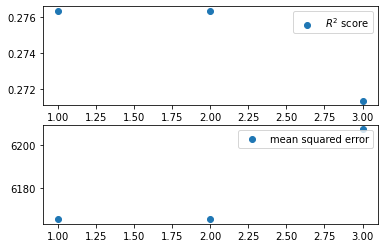

In [15]:
# plot to compare
fig, ax = plt.subplots(2)
ax[0].scatter([1, 2, 3], [r2_lr, r2_rr, r2_las], label='$R^2$ score')
ax[0].legend(loc='best')
ax[1].scatter([1, 2, 3], [mse_lr, mse_rr, mse_las], label='mean squared error')
ax[1].legend(loc='best')

使用支持向量机来做回归分析，以及用集成模型的Adaboost和随机森林

In [16]:
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor

In [17]:
# SVM 支持向量机
svm = SVR(kernel='rbf')
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)
r2_svm = svm.score(X_test, y_test)
mse_svm = mean_squared_error(y_true=y_test, y_pred=y_pred_svm)

# Adaboost
AdaBoost = AdaBoostRegressor(n_estimators=100)
AdaBoost.fit(X_train, y_train)
y_pred_ada = AdaBoost.predict(X_test)
r2_AdaBoost = AdaBoost.score(X_test, y_test)
mse_AdaBoost = mean_squared_error(y_true=y_test, y_pred=y_pred_ada)

# Random Forest 随机森林
RandomForest = RandomForestRegressor(n_estimators=20)
RandomForest.fit(X_train,y_train)
y_pred_for = AdaBoost.predict(X_test)
r2_RandomForest = RandomForest.score(X_test,y_test)
mse_RandomForest = mean_squared_error(y_true=y_test, y_pred=y_pred_for)

打印出三种模型的各种分数

In [18]:
print('mean squre error:')
print('SVM: {}'.format(mse_svm))
print('AdaBoost: {}'.format(mse_AdaBoost))
print('RandomForest: {}'.format(mse_RandomForest))

print('R^2 score:')
print('SVM: {}'.format(r2_svm))
print('AdaBoost: {}'.format(r2_AdaBoost))
print('RandomForest: {}'.format(r2_RandomForest))

mean squre error:
SVM: 8630.098994486236
AdaBoost: 7457.3592417036225
RandomForest: 7457.3592417036225
R^2 score:
SVM: -0.012981991427850614
AdaBoost: 0.12467161497450086
RandomForest: 0.30710290266224183


In [ ]:
# plot to compare
fig, ax = plt.subplots(2)
ax[0].scatter([1, 2, 3], [r2_lr, r2_rr, r2_las], label='$R^2$ score')
ax[0].legend(loc='best')
ax[1].scatter([1, 2, 3], [mse_lr, mse_rr, mse_las], label='mean squared error')
ax[1].legend(loc='best')

用mlxtend包

In [19]:
from mlxtend.regressor import StackingRegressor

base model
mean squre error: 6165.064394276775
mean squre error: 12167.586659585688
mean squre error: 7624.542696989568
mean squre error: 6165.071856420479
stacking model
mean squre error: 5525.963085650848


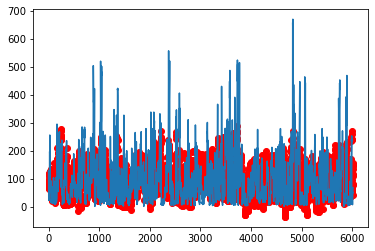

In [20]:
# 初始化基模型
lr = LinearRegression()
svr_lin = SVR(kernel='linear', gamma='auto')
svr_rbf = SVR(kernel='rbf', gamma='auto')
ridge = Ridge(random_state=2019)
models = [lr, svr_lin, svr_rbf, ridge]

print('base model')
for model in models:
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    mse = mean_squared_error(y_test, pred)
    print("mean squre error: {}".format(mse))
sclf = StackingRegressor(regressors=models, meta_regressor=ridge)
# 训练回归器
sclf.fit(X_train, y_train)
y_pred = sclf.predict(X_test)

print('stacking model')
print("mean squre error: {}".format(mean_squared_error(y_test, y_pred)))
plt.scatter(np.arange(len(y_pred)), y_pred, c='red')
plt.plot(np.arange(len(y_test)), y_test)
plt.show()

In [21]:
sclf.score(X_test,y_test)

0.35137463722771267

## 四、数据可视化

In [ ]:
# data visulization
plt.plot(no_nan_df['season'], no_nan_df['pm2.5'], label='PM2.5')

In [ ]:

b1 = sns.boxplot(x='grade',y='pm2.5',data=no_nan_df,hue='year')
b2 = sns.boxplot(x='grade',y='pm2.5',data=no_nan_df,hue='season')